# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
#helper.download_extract('celeba', data_dir)

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

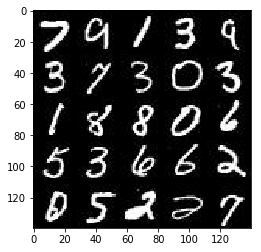

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

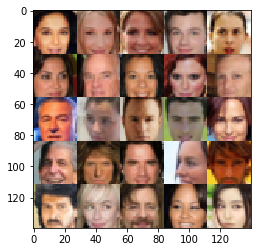

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return (inputs_real, inputs_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=0.2)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=0.2)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=0.2)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    #saver = tf.train.Saver()
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, learn_rate:learning_rate})
                sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z, learn_rate:learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}...".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.2629... Generator Loss: 1.6684
Epoch 1/2... Discriminator Loss: 0.0204... Generator Loss: 4.9361
Epoch 1/2... Discriminator Loss: 0.8206... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 0.1557... Generator Loss: 2.1649
Epoch 1/2... Discriminator Loss: 0.0529... Generator Loss: 3.6900
Epoch 1/2... Discriminator Loss: 0.6290... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 0.3652... Generator Loss: 4.4112
Epoch 1/2... Discriminator Loss: 0.8512... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 0.7198... Generator Loss: 0.9233
Epoch 1/2... Discriminator Loss: 0.9457... Generator Loss: 0.7790


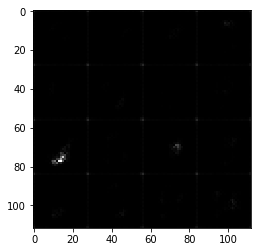

Epoch 1/2... Discriminator Loss: 0.8277... Generator Loss: 0.9475
Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 1.6712
Epoch 1/2... Discriminator Loss: 1.0865... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.0976... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 1.6272... Generator Loss: 1.3605
Epoch 1/2... Discriminator Loss: 1.4201... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.4077
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.5511
Epoch 1/2... Discriminator Loss: 0.8739... Generator Loss: 1.1428


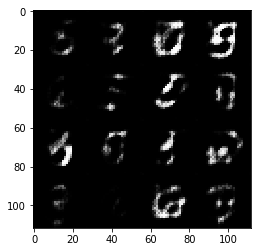

Epoch 1/2... Discriminator Loss: 1.4564... Generator Loss: 0.3669
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 1.1071
Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 0.9008
Epoch 1/2... Discriminator Loss: 1.3101... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.4247
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.8107
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 1.5948... Generator Loss: 0.2856


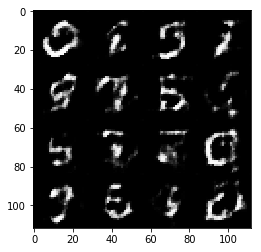

Epoch 1/2... Discriminator Loss: 1.6831... Generator Loss: 0.2476
Epoch 1/2... Discriminator Loss: 1.5124... Generator Loss: 0.3056
Epoch 1/2... Discriminator Loss: 1.2407... Generator Loss: 0.4864
Epoch 1/2... Discriminator Loss: 1.1040... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.6195... Generator Loss: 0.3109
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.7779
Epoch 1/2... Discriminator Loss: 1.3636... Generator Loss: 0.6113
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.4758
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.5292... Generator Loss: 0.4448


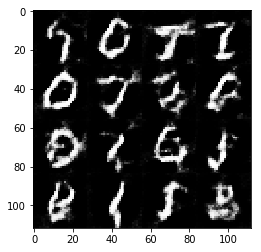

Epoch 1/2... Discriminator Loss: 1.5430... Generator Loss: 0.4059
Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.4648
Epoch 1/2... Discriminator Loss: 1.7187... Generator Loss: 0.2413
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 0.6302
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 1.1875
Epoch 1/2... Discriminator Loss: 1.2631... Generator Loss: 0.8107
Epoch 1/2... Discriminator Loss: 1.3859... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 1.7659... Generator Loss: 0.2906
Epoch 1/2... Discriminator Loss: 1.3302... Generator Loss: 1.3507
Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 1.1899


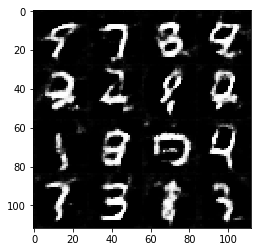

Epoch 1/2... Discriminator Loss: 1.3095... Generator Loss: 0.8679
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.3932
Epoch 1/2... Discriminator Loss: 1.1352... Generator Loss: 1.1382
Epoch 1/2... Discriminator Loss: 1.4379... Generator Loss: 0.4077
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.5928
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.1412... Generator Loss: 0.9489
Epoch 1/2... Discriminator Loss: 1.6461... Generator Loss: 0.2762
Epoch 1/2... Discriminator Loss: 1.4632... Generator Loss: 0.4673
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 0.5314


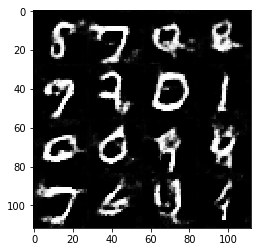

Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 0.6823
Epoch 1/2... Discriminator Loss: 1.0146... Generator Loss: 1.3304
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.6194
Epoch 1/2... Discriminator Loss: 1.6573... Generator Loss: 0.2552
Epoch 1/2... Discriminator Loss: 1.4103... Generator Loss: 0.3537
Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 0.6273
Epoch 1/2... Discriminator Loss: 1.2600... Generator Loss: 0.4643
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 0.8778
Epoch 1/2... Discriminator Loss: 1.3984... Generator Loss: 0.3680
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.8166


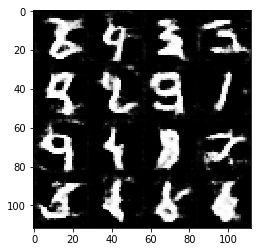

Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 0.7960
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 0.6703
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 1.1643
Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 0.6663
Epoch 1/2... Discriminator Loss: 1.1517... Generator Loss: 0.5130
Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 1.1328
Epoch 1/2... Discriminator Loss: 1.2706... Generator Loss: 0.5632
Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 0.5702


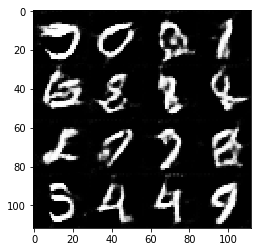

Epoch 1/2... Discriminator Loss: 1.0668... Generator Loss: 0.6637
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.4152
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.4159... Generator Loss: 0.4591
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 0.5780
Epoch 1/2... Discriminator Loss: 1.3305... Generator Loss: 0.4601
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.4731
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.4358
Epoch 1/2... Discriminator Loss: 1.2141... Generator Loss: 0.5408
Epoch 1/2... Discriminator Loss: 1.3632... Generator Loss: 0.4274


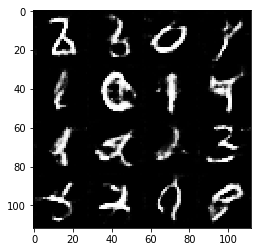

Epoch 1/2... Discriminator Loss: 1.0898... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 1.5820... Generator Loss: 0.2729
Epoch 1/2... Discriminator Loss: 1.6536... Generator Loss: 0.2552
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.5812
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 0.5978
Epoch 2/2... Discriminator Loss: 0.9867... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 1.0424... Generator Loss: 0.7801
Epoch 2/2... Discriminator Loss: 1.5322... Generator Loss: 0.3341
Epoch 2/2... Discriminator Loss: 1.3452... Generator Loss: 0.5016


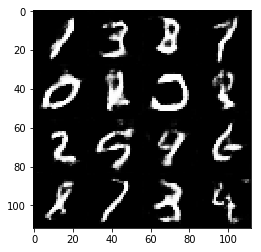

Epoch 2/2... Discriminator Loss: 0.9791... Generator Loss: 0.7231
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 0.6182
Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 0.3317
Epoch 2/2... Discriminator Loss: 1.8243... Generator Loss: 0.2008
Epoch 2/2... Discriminator Loss: 1.1560... Generator Loss: 0.6576
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.4384
Epoch 2/2... Discriminator Loss: 1.5262... Generator Loss: 0.3705
Epoch 2/2... Discriminator Loss: 0.8395... Generator Loss: 1.2310
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 0.7289
Epoch 2/2... Discriminator Loss: 1.4149... Generator Loss: 0.4103


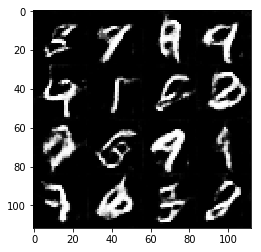

Epoch 2/2... Discriminator Loss: 1.6045... Generator Loss: 0.2662
Epoch 2/2... Discriminator Loss: 1.6390... Generator Loss: 0.2509
Epoch 2/2... Discriminator Loss: 1.7553... Generator Loss: 0.2322
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 0.9460
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.4189
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 0.9956
Epoch 2/2... Discriminator Loss: 1.1350... Generator Loss: 1.7938
Epoch 2/2... Discriminator Loss: 1.4921... Generator Loss: 0.3696
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 0.5866
Epoch 2/2... Discriminator Loss: 1.5933... Generator Loss: 0.2685


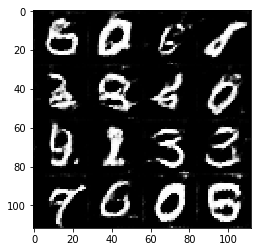

Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.5021
Epoch 2/2... Discriminator Loss: 1.4225... Generator Loss: 0.3468
Epoch 2/2... Discriminator Loss: 1.4279... Generator Loss: 0.3317
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 1.5099
Epoch 2/2... Discriminator Loss: 1.1568... Generator Loss: 0.5263
Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 1.1305
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 0.5318
Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 0.7763
Epoch 2/2... Discriminator Loss: 1.3787... Generator Loss: 0.3579
Epoch 2/2... Discriminator Loss: 1.8276... Generator Loss: 0.2130


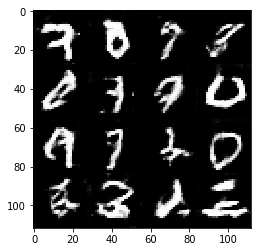

Epoch 2/2... Discriminator Loss: 1.1616... Generator Loss: 0.5574
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.3984
Epoch 2/2... Discriminator Loss: 1.4002... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 1.3141... Generator Loss: 1.0526
Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 1.2267
Epoch 2/2... Discriminator Loss: 1.7252... Generator Loss: 0.2329
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 0.9952... Generator Loss: 0.8038
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 0.5579
Epoch 2/2... Discriminator Loss: 1.6388... Generator Loss: 0.2927


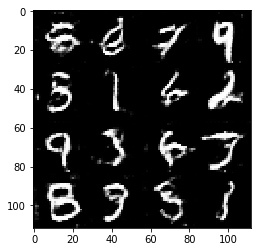

Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.3935
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.7448
Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 0.9345
Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 0.4298
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 0.6050
Epoch 2/2... Discriminator Loss: 1.0365... Generator Loss: 0.9064
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.6280
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 0.9953


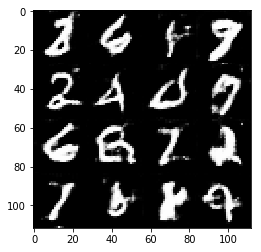

Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 1.6305
Epoch 2/2... Discriminator Loss: 1.6421... Generator Loss: 0.2731
Epoch 2/2... Discriminator Loss: 0.8664... Generator Loss: 0.7965
Epoch 2/2... Discriminator Loss: 1.2633... Generator Loss: 1.5901
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 0.6619
Epoch 2/2... Discriminator Loss: 0.9671... Generator Loss: 0.7296
Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 1.1614
Epoch 2/2... Discriminator Loss: 0.8473... Generator Loss: 1.1937
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 0.7984


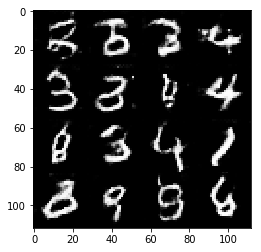

Epoch 2/2... Discriminator Loss: 1.0890... Generator Loss: 0.5655
Epoch 2/2... Discriminator Loss: 1.6722... Generator Loss: 0.2508
Epoch 2/2... Discriminator Loss: 0.9377... Generator Loss: 0.6736
Epoch 2/2... Discriminator Loss: 0.8420... Generator Loss: 0.9490
Epoch 2/2... Discriminator Loss: 0.8275... Generator Loss: 0.9280
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 2.6812
Epoch 2/2... Discriminator Loss: 1.2166... Generator Loss: 0.4587
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 0.4661
Epoch 2/2... Discriminator Loss: 1.7970... Generator Loss: 0.2156
Epoch 2/2... Discriminator Loss: 1.0990... Generator Loss: 0.9489


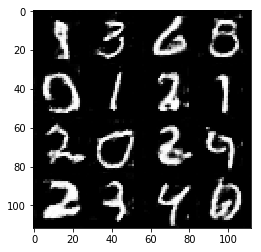

Epoch 2/2... Discriminator Loss: 1.2770... Generator Loss: 0.4395
Epoch 2/2... Discriminator Loss: 1.3995... Generator Loss: 0.3597
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 1.1777... Generator Loss: 0.5039
Epoch 2/2... Discriminator Loss: 1.1284... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.5425
Epoch 2/2... Discriminator Loss: 1.0571... Generator Loss: 0.4904
Epoch 2/2... Discriminator Loss: 0.9475... Generator Loss: 1.2644
Epoch 2/2... Discriminator Loss: 1.4250... Generator Loss: 2.0091
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.4637


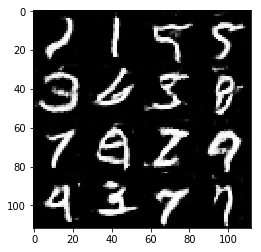

Epoch 2/2... Discriminator Loss: 1.0182... Generator Loss: 0.6197
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.3703
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 0.5132
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.4989
Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 1.4507
Epoch 2/2... Discriminator Loss: 1.2947... Generator Loss: 0.4042
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 0.9179


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 1.6212
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 3.7251
Epoch 1/1... Discriminator Loss: 2.4473... Generator Loss: 0.1130
Epoch 1/1... Discriminator Loss: 0.2666... Generator Loss: 2.3883
Epoch 1/1... Discriminator Loss: 1.6770... Generator Loss: 0.2747
Epoch 1/1... Discriminator Loss: 0.6919... Generator Loss: 2.8516
Epoch 1/1... Discriminator Loss: 1.6053... Generator Loss: 8.9788
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 6.7336
Epoch 1/1... Discriminator Loss: 0.3033... Generator Loss: 2.7236


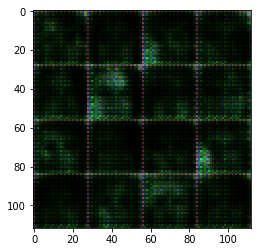

Epoch 1/1... Discriminator Loss: 2.8756... Generator Loss: 0.0974
Epoch 1/1... Discriminator Loss: 0.1045... Generator Loss: 3.0228
Epoch 1/1... Discriminator Loss: 0.1990... Generator Loss: 2.9738
Epoch 1/1... Discriminator Loss: 0.6735... Generator Loss: 8.6672
Epoch 1/1... Discriminator Loss: 0.7308... Generator Loss: 0.8147
Epoch 1/1... Discriminator Loss: 3.6280... Generator Loss: 7.4965
Epoch 1/1... Discriminator Loss: 2.6276... Generator Loss: 0.1021
Epoch 1/1... Discriminator Loss: 1.8168... Generator Loss: 0.2600
Epoch 1/1... Discriminator Loss: 0.5926... Generator Loss: 2.6880
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.3370


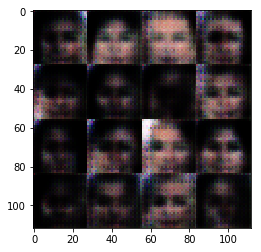

Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.4992
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.7286... Generator Loss: 0.2727
Epoch 1/1... Discriminator Loss: 1.9291... Generator Loss: 0.2609
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.7556... Generator Loss: 0.3494
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.9832
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5574


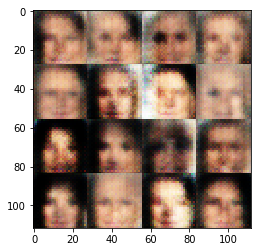

Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 2.2155... Generator Loss: 0.1663
Epoch 1/1... Discriminator Loss: 2.5780... Generator Loss: 0.1019
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.2534
Epoch 1/1... Discriminator Loss: 1.6515... Generator Loss: 0.4040
Epoch 1/1... Discriminator Loss: 1.8553... Generator Loss: 0.2771
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.2059
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 2.2794... Generator Loss: 0.1712


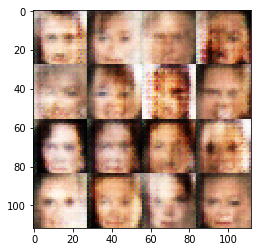

Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.8585... Generator Loss: 0.2405
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.3589
Epoch 1/1... Discriminator Loss: 2.1757... Generator Loss: 0.1613
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.0128
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.7485


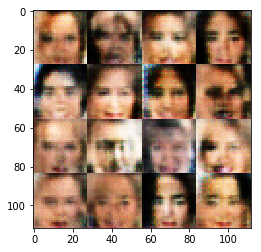

Epoch 1/1... Discriminator Loss: 1.9125... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 1.5494
Epoch 1/1... Discriminator Loss: 2.1271... Generator Loss: 0.1798
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.1064
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 0.7439... Generator Loss: 2.6789
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 0.9929


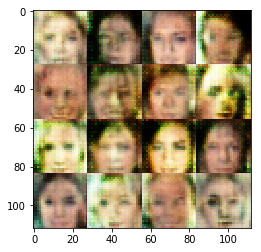

Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.5658
Epoch 1/1... Discriminator Loss: 2.1654... Generator Loss: 0.2001
Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 2.1801
Epoch 1/1... Discriminator Loss: 1.5949... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 0.4152... Generator Loss: 1.9432
Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 2.0330
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.4049
Epoch 1/1... Discriminator Loss: 2.0171... Generator Loss: 0.1832
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.5844


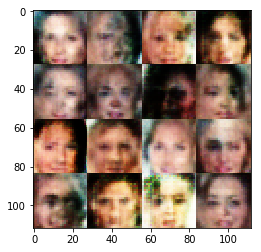

Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 1.0539
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.5803... Generator Loss: 0.3438
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 1.6629... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 1.7463
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.7112... Generator Loss: 0.2414


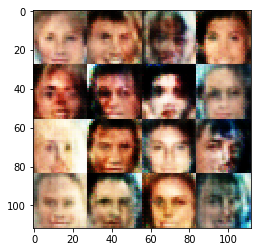

Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.4064
Epoch 1/1... Discriminator Loss: 2.1144... Generator Loss: 0.1603
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 2.0685... Generator Loss: 0.2185
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.6948... Generator Loss: 1.5018
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 1.1056
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.8198... Generator Loss: 1.9022
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.3818


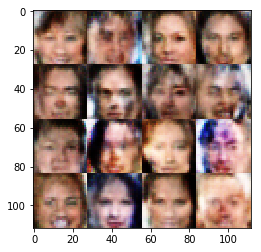

Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.3659
Epoch 1/1... Discriminator Loss: 1.8056... Generator Loss: 0.3050
Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.4908
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.7092... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 2.4910
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.4376


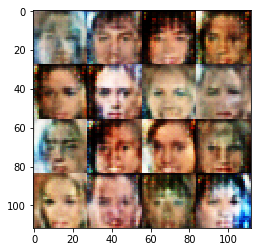

Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.6652... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.6061... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.6013... Generator Loss: 0.4292
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.9484


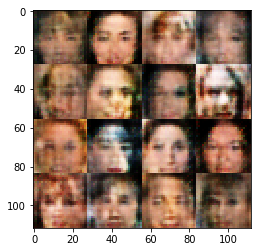

Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.3131
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5544
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 1.8532
Epoch 1/1... Discriminator Loss: 1.6360... Generator Loss: 0.2691
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.6553


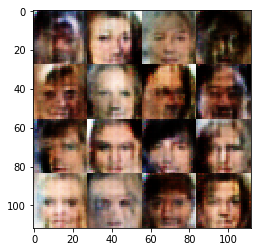

Epoch 1/1... Discriminator Loss: 1.6431... Generator Loss: 0.2886
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.9585
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.6891
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 1.5231
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.8997
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 2.4798


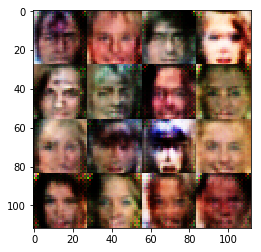

Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.4472
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 1.5198
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 1.8154
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 1.1038


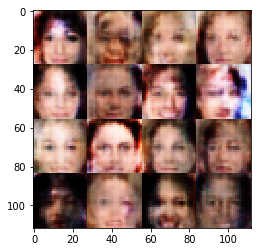

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 1.5674... Generator Loss: 0.3153
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.7310... Generator Loss: 1.7043
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 2.0769... Generator Loss: 0.2210
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 0.4178... Generator Loss: 1.6446
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.4240


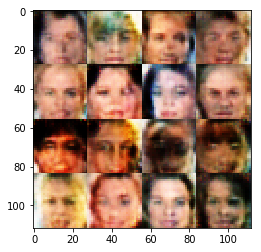

Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 0.3645
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.1740... Generator Loss: 2.2709
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 2.9614... Generator Loss: 2.4102
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 0.6456


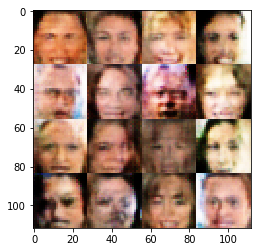

Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.4361
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 2.4713... Generator Loss: 0.1405
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.5561... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6482


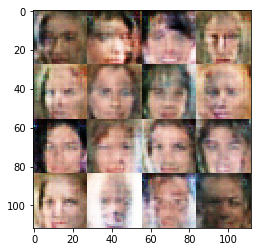

Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.5242... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.4822
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6226


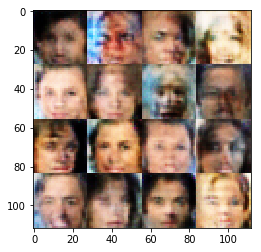

Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.0029... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.5537... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.7206... Generator Loss: 0.4336
Epoch 1/1... Discriminator Loss: 0.9915... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.5551


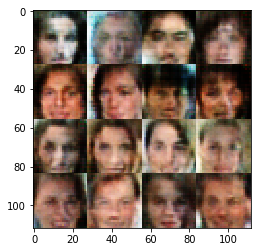

Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.4755
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 1.0666


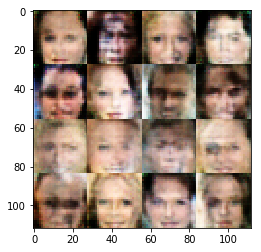

KeyboardInterrupt: 

In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.